# Intro

All I really know right now is that I want to find linearly seperable variables in 2-space for the two 8-second water flow clips I just recorded. I have found a library, Librosa, that seems like it will be of some help. Here we go!!


In [1]:
# not mine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import find_peaks
from scipy import signal

import librosa
import librosa.display

## Annotations/Enums

In [2]:
from typing import Annotated
from numpy import ndarray

Seconds = Annotated[int, 'seconds']
Recording = Annotated[ndarray, 'recording']

In [3]:
from enum import Enum, auto

class AutoName(Enum):
    def _generate_next_value_(self, start, count, last_values):
        return self


class WaterState(AutoName):
    OFF = auto()
    DRIP = auto()
    FULL = auto()

In [4]:
filename = "water_data/data.csv"
filename_hard = "water_data_harder/data.csv"

The first thing that I would like to do would be to look at the spectogram for this. No real reason why other than I've seen this kind of thing before for other audio applications and I wonder if it might look different for our three different recordings. Remember, we have:

- Off = Pretty much dead silent for now
- Drip = I manufactured a drip in my kitchen sink and recorded it
- Full = Some amount of regular water usage, ez mode is fully on, hard mode is barely on like you might accidentally leave on


In [5]:
# reads the data in

def read_sample_recordings(f: str) -> (list[Recording], pd.DataFrame):
    df = pd.read_csv(f)
    off, drip, full = df[str(WaterState.OFF)], df[str(WaterState.DRIP)], df[str(WaterState.FULL)]
    samples: list[Recording] = [off.to_numpy(), drip.to_numpy(), full.to_numpy()]
    return samples, df


In [6]:
recordings, audio_df = read_sample_recordings(filename)
recordings_hard, audio_hard_df = read_sample_recordings(filename_hard)

In [372]:
audio_df.head()

# This is just the raw audio signal!

,Unnamed: 0,WaterState.OFF,WaterState.DRIP,WaterState.FULL
0,0,-7.481016e-13,-0.000827,-0.008584
1,1,2.391683e-08,-0.000900,-0.017730
2,2,1.418812e-06,-0.001003,-0.011707
3,3,2.221116e-05,-0.001042,-0.009546
4,4,1.497682e-04,-0.001125,0.012170


In [373]:
def show_spectogram_for_(audio: Recording):
    D = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db)
    plt.colorbar()
    plt.show()

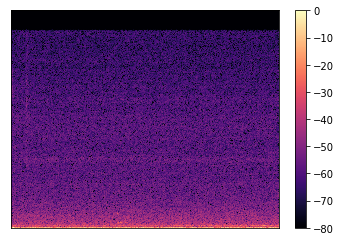

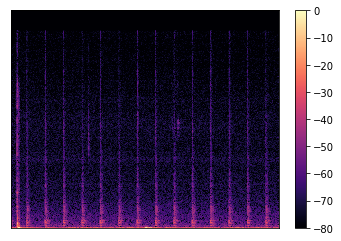

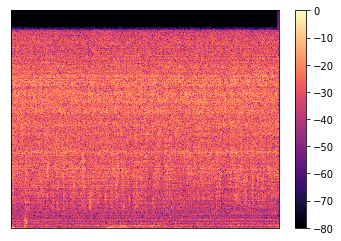

In [374]:
for audio in recordings:
    show_spectogram_for_(audio)

From the above, it looks like we have some pretty big differences between the three audio files. I'm curious if we have the same clarity in the harder version. I'm also curious if we can determine a drip based off a detection of tempo? Let's look at the less defined training set first:

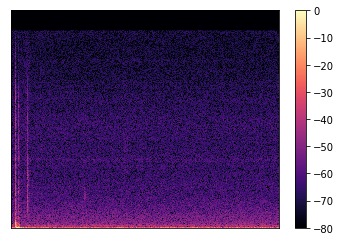

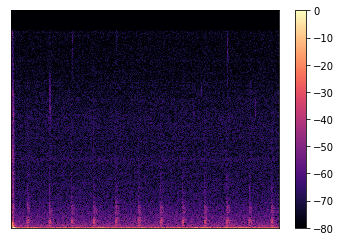

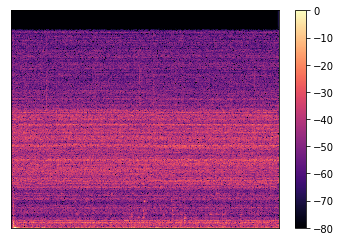

In [375]:
for audio in recordings_hard:
    show_spectogram_for_(audio)

To be honest, this one looks nearly as convincing, just less contrast due to the quieter amplitude. This is good news! My first thought is that a faucet being on is close to white noise so I looked through Librosa for things that might detect white noise and I found one!

## Feature - White Noise/Amplitude

I think that water being on might look like white noise vs water being off/dripping. I started with the [Short-Time Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) and then extracted the magnitude/amplitude of the signal from that.

In [376]:
def argand(a):
    for x in range(len(a)):
        plt.plot([0,a[x].real],[0,a[x].imag],'ro-',label='python')
    limit=np.max(np.ceil(np.absolute(a))) # set limits for axis
    plt.xlim((-limit,limit))
    plt.ylim((-limit,limit))
    plt.ylabel('Imaginary')
    plt.xlabel('Real')
    plt.show()

In [377]:
# this does a super common transformation I haven't looked into yet
# then converts to magnitude, phase breakouts
# I use the magnitude
def show_amplitude_for_(audio: Recording):
    S, phase = librosa.magphase(librosa.stft(audio))
    
    avg = mean([np.max(a) for a in S]) 
    print(f"Average: {avg}")
    
    plt.plot(S)
    plt.show()

Average: 0.00952851124193176


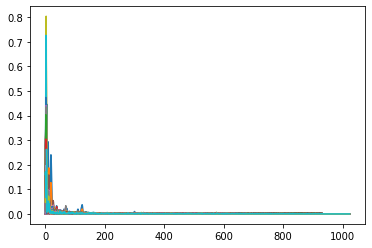

Average: 0.06267882935582081


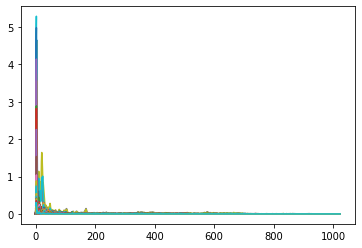

Average: 0.8800049363508679


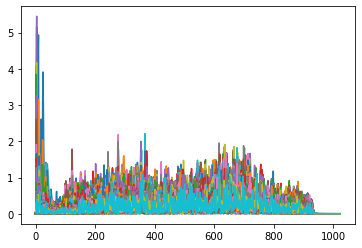

In [378]:
    for audio in recordings:
        show_amplitude_for_(audio)

Average: 0.036079711204988305


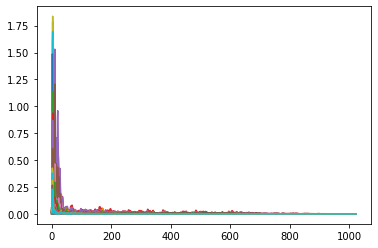

Average: 0.045396647437845064


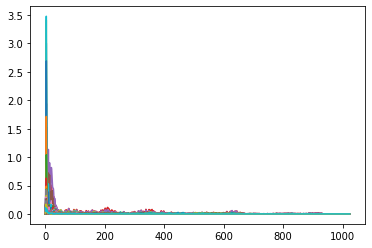

Average: 0.12841406696634028


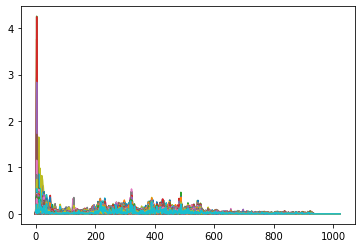

In [379]:
    for audio in recordings_hard:
        show_amplitude_for_(audio)

From the above, it looks like if we take the average of the maxes of the amplitude, we can separate out pretty well between off/dripping and on. This makes sense but it's also good news!

I can make more training datasets but I could have had the water a little quieter so I'd say that 0.1 is probably a resonable-ish cutoff. But I suppose the SVM will be deciding that haha!

## Feature - Tempo

Now let's find out if we can detect tempo at all!

In [380]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [381]:
def show_tempogram_for_(audio: Recording):
    t = librosa.feature.tempogram(audio)
    #_, Pxx_den = signal.periodogram(t, fs)
    
    avgs = []
    for a in t:
        avgs.append(np.mean(a))
                    
    avgs = [exp for exp in avgs]
    inds = [i for i in range(0, len(avgs))]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(inds,avgs)
    
    peaks = find_peaks(avgs, prominence=0.05)
    print(f"Peak count: {len(peaks[0])}")
    
    plt.plot(avgs)
    x = peaks[0]
    y = [avgs[peak] for peak in peaks[0]]
    plt.plot(x, y, "x")
    
    abline(slope, intercept)
    plt.show()

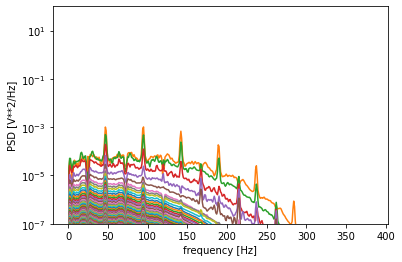

In [382]:
fs = 10e3

t = librosa.feature.tempogram(recordings[1])
f, Pxx_den = signal.periodogram(t, fs)


#print(f, Pxx_den)
plt.semilogy(Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

Peak count: 0


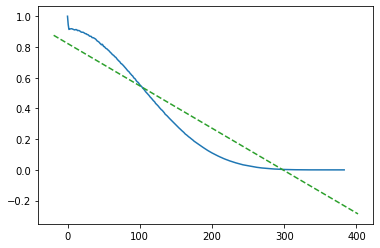

Peak count: 5


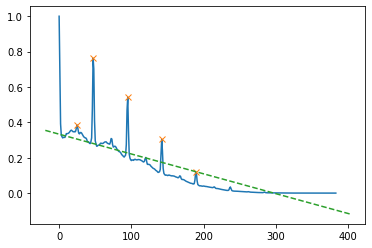

Peak count: 0


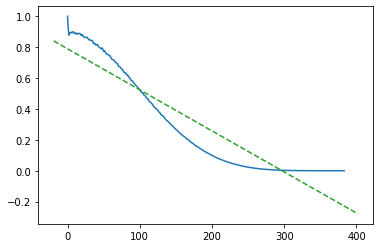

In [383]:
for audio in recordings:
    show_tempogram_for_(audio)

Peak count: 0


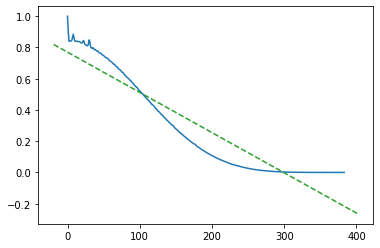

Peak count: 2


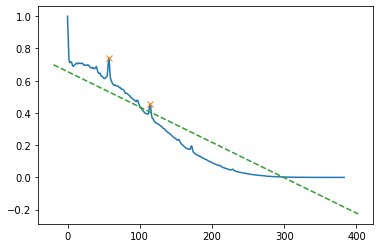

Peak count: 0


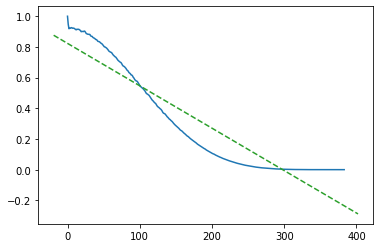

In [385]:
for audio in recordings_hard:
    show_tempogram_for_(audio)

It would also seem that if the tempogram has peaks, we can assume that it has some sort of regualar percussive action going on, perhaps dripping!